# 3. Missing-Data Imputation  

> “Missing values should be handled carefully to avoid biased results.” — Gotten from the OECD Handbook on Composite Indicators

It is without doubt that there will be missing data in any financial dataset just like the Russell 3000 universe which could be caused by late filings, thin traded days and IPO - Investment Blackout periods.

In this notebook  I will:

1. Diagnose the missingness pattern
2. Choose methods that balance robustness and runtime
3. Generate *five multiply-imputed* fundamental data sets (MICE)
4. Forward-fill price-series gaps
5. Save artefacts 

## 3.1. Missingness Diagnosis  

There are three types of missingness that I read in the OECD Handbook on Composite Indicators:

* **MCAR** – Missing Completely At Random  
* **MAR**  – Missing At Random (conditioned on observed data)  
* **NMAR** – Not Missing At Random (depends on the unobserved value)  

True NMAR is rare in public equity fundamentals (Taking filing delays aside). So in this case I will just assume that the missingness is MAR and verify by looking at correlations between missingness flags and available metrics.

Columns with >30 % missing:


trailingPE                 0.312524
earningsQuarterlyGrowth    0.402653
dividendDate               0.404604
lastDividendValue          0.404994
lastDividendDate           0.404994
dtype: float64

Top 10 most missing indicators:


industrySymbol                  0.99961
beta3Year                       0.99961
legalType                       0.99961
trailingThreeMonthNavReturns    0.99961
trailingThreeMonthReturns       0.99961
netAssets                       0.99961
fiveYearAverageReturn           0.99961
fundInceptionDate               0.99961
totalAssets                     0.99961
threeYearAverageReturn          0.99961
dtype: float64

/var/folders/8s/y5bjlk5x3bsbdbx_ndzgpj5h0000gn/T/ipykernel_27181/2994604561.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_cols.index, y=missing_cols.values, palette="viridis")


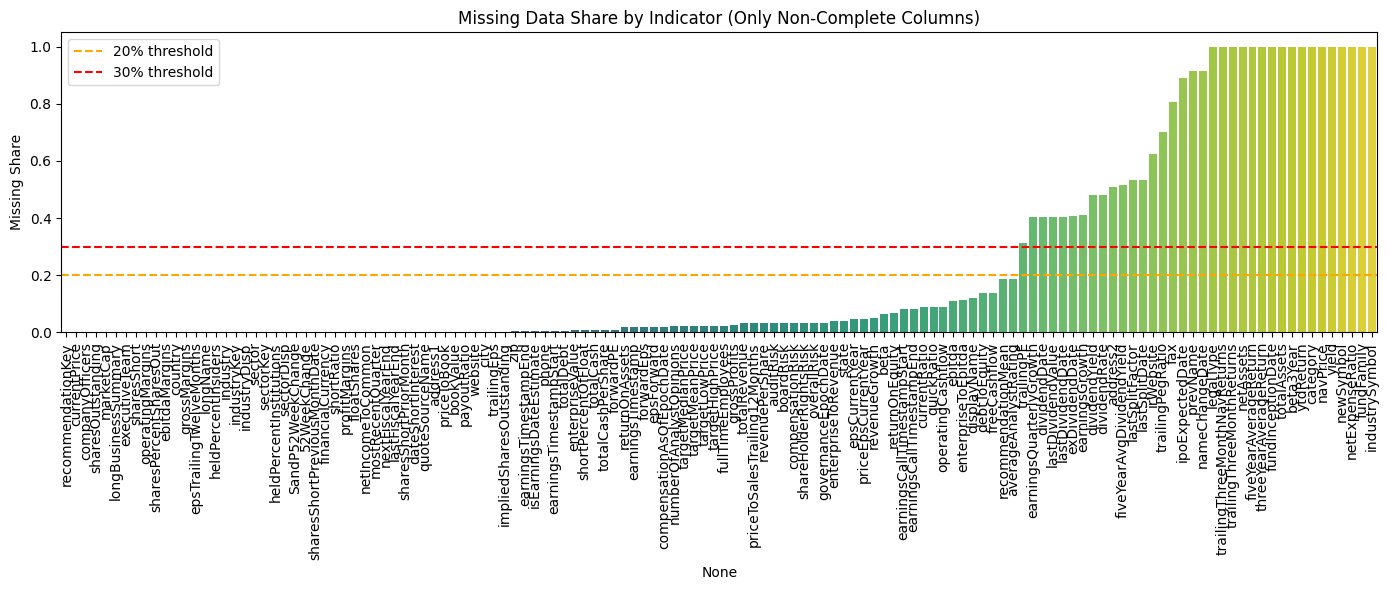

In [7]:
# to diagnose missingness
import pandas as pd, numpy as np, joblib, glob, re, json, datetime as dt
from pathlib import Path
import seaborn as sns, matplotlib.pyplot as plt

DATA_DIR = Path("..") / "data"
RAW_DIR = DATA_DIR / "raw"
ART_DIR = Path("..") / "artifacts"
ART_DIR.mkdir(exist_ok=True)

# to get the list of all funds
funds = [joblib.load(p) for p in glob.glob(str(RAW_DIR / "info_*.pkl"))]
df_raw = pd.DataFrame(funds)

missing_share = df_raw.isna().mean().sort_values()
missing_share.to_csv(ART_DIR / "missing_share_fundamentals.csv")

print("Columns with >30 % missing:")
display(missing_share[missing_share > 0.3].head())

print("Top 10 most missing indicators:")
display(missing_share.sort_values(ascending=False).head(10))

missing_cols = missing_share[missing_share > 0]

plt.figure(figsize=(14, 6))
sns.barplot(x=missing_cols.index, y=missing_cols.values, palette="viridis")
plt.xticks(rotation=90)
plt.ylabel("Missing Share")
plt.title("Missing Data Share by Indicator (Only Non-Complete Columns)")
plt.tight_layout()
plt.axhline(0.2, ls="--", c="orange", label="20% threshold")
plt.axhline(0.3, ls="--", c="red", label="30% threshold")
plt.legend()
plt.show()